Total data: 6322 days (2000-10-17 to 2025-12-05)
Trading starts: 2021-12-31 (index 5335)

Processing 987 windows...

Progress: 0/987 (0.0%)
Progress: 50/987 (5.1%)
Progress: 100/987 (10.1%)
Progress: 150/987 (15.2%)
Progress: 200/987 (20.3%)
Progress: 250/987 (25.3%)
Progress: 300/987 (30.4%)
Progress: 350/987 (35.5%)
Progress: 400/987 (40.5%)
Progress: 450/987 (45.6%)
Progress: 500/987 (50.7%)
Progress: 550/987 (55.7%)
Progress: 600/987 (60.8%)
Progress: 650/987 (65.9%)
Progress: 700/987 (70.9%)
Progress: 750/987 (76.0%)
Progress: 800/987 (81.1%)
Progress: 850/987 (86.1%)
Progress: 900/987 (91.2%)
Progress: 950/987 (96.3%)

Forecasting complete!

PERFORMANCE RESULTS
Period: 2021-12-31 to 2025-12-05

Strategy Return:       -30.48%
Buy & Hold Return:        59.72%
Excess Return:       -90.20%

Strategy Sharpe:        -0.32
Buy & Hold Sharpe:         0.42

Max Drawdown:       -52.76%
Win Rate:        49.49%

Total Trades:          986
Long Positions:          627
Short Positions:        

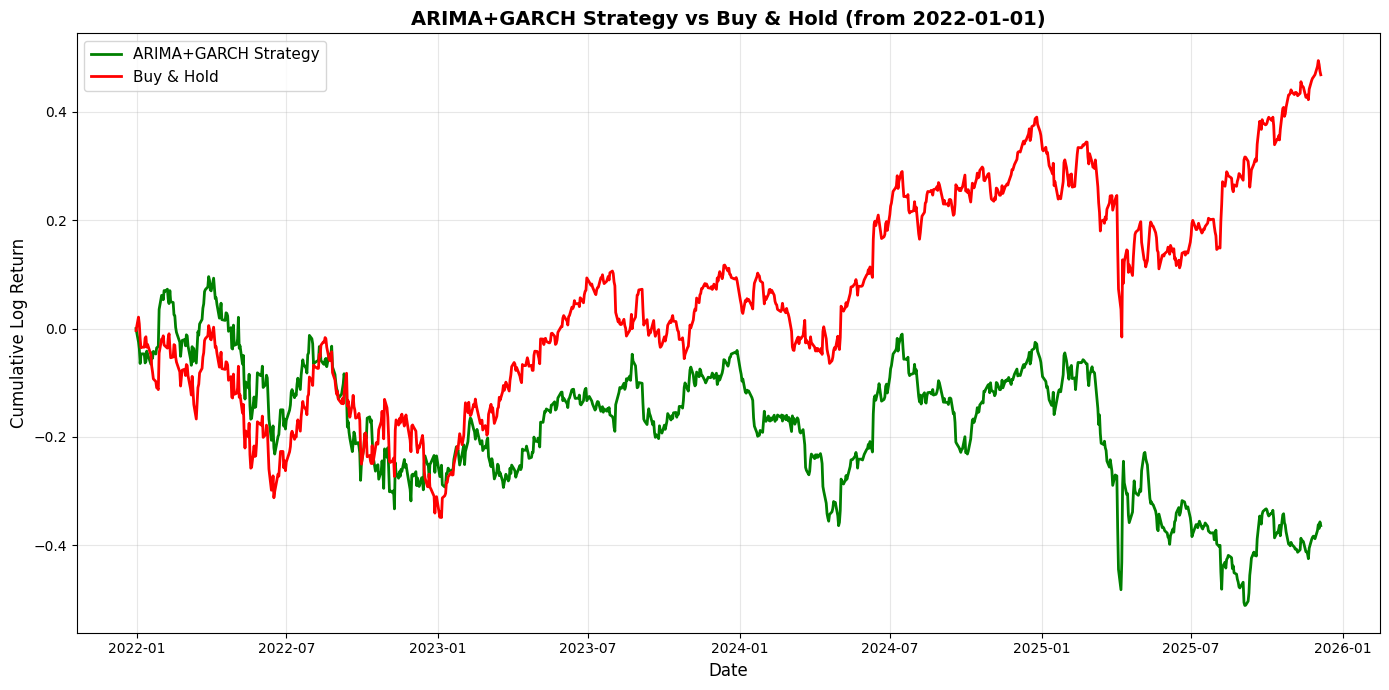

In [1]:
import sqlite3
from pathlib import Path
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


# ==================== CONFIGURATION ====================
DB_PATH = Path("data/processed/data_processed.sqlite")
START_DATE = "2022-01-01"
WINDOW_LENGTH = 500
P_MAX = 5
Q_MAX = 5
# =======================================================


def load_data_from_sqlite():
    """Load stock data from SQLite."""
    with sqlite3.connect(DB_PATH) as conn:
        tables = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)
        if tables.empty:
            raise RuntimeError(f"No tables found in {DB_PATH}")
        table_name = tables["name"].iloc[0]
        
        df = pd.read_sql(
            f'SELECT Date, Close FROM "{table_name}" ORDER BY Date', 
            conn, 
            parse_dates=["Date"]
        )
    
    df = df.set_index("Date")
    df['returns'] = np.log(df['Close']).diff()
    df = df.dropna(subset=['returns'])
    
    return df


# Load ALL data
df = load_data_from_sqlite()
returns = df['returns'].values
dates = df.index

print(f"Total data: {len(df)} days ({dates[0].date()} to {dates[-1].date()})")

# Find START_DATE index
start_idx = df.index.get_indexer([pd.to_datetime(START_DATE)], method='nearest')[0]
print(f"Trading starts: {dates[start_idx].date()} (index {start_idx})")

if start_idx < WINDOW_LENGTH:
    raise ValueError(f"Need {WINDOW_LENGTH} days before {START_DATE}. Only have {start_idx} days.")

# Calculate forecasts from START_DATE onwards
forecasts_length = len(returns) - start_idx
forecasts = np.zeros(forecasts_length)
directions = np.zeros(forecasts_length)

print(f"\nProcessing {forecasts_length} windows...\n")

for i in range(forecasts_length):
    if i % 50 == 0:
        print(f"Progress: {i}/{forecasts_length} ({100*i/forecasts_length:.1f}%)")
    
    # Rolling window: WINDOW_LENGTH days ending at (start_idx + i)
    window_start = start_idx + i - WINDOW_LENGTH
    window_end = start_idx + i
    roll_returns = returns[window_start:window_end]
    
    # Find best ARIMA model
    final_aic = np.inf
    final_order = (0, 0, 0)
    
    for p in range(0, P_MAX + 1):
        for q in range(0, Q_MAX + 1):
            if p == 0 and q == 0:
                continue
            
            try:
                model = ARIMA(roll_returns, order=(p, 0, q)).fit(disp=0)
                current_aic = model.aic
                
                if current_aic < final_aic:
                    final_aic = current_aic
                    final_order = (p, 0, q)
            except:
                continue
    
    if final_order == (0, 0, 0):
        final_order = (1, 0, 1)
    
    # Fit GARCH(1,1) model
    try:
        spec = arch_model(
            roll_returns,
            mean='ARX',
            lags=final_order[0],
            vol='GARCH',
            p=1,
            q=1,
            dist='skewt'
        )
        fit = spec.fit(disp='off', show_warning=False)
        
        fore = fit.forecast(horizon=1)
        forecast_value = fore.mean.iloc[-1, 0]
        
        forecasts[i] = forecast_value
        directions[i] = 1 if forecast_value > 0 else -1
        
    except:
        forecasts[i] = 0
        directions[i] = 1

print("\nForecasting complete!\n")

# Create series starting from START_DATE
forecast_dates = dates[start_idx:]
forecasts_series = pd.Series(forecasts, index=forecast_dates)
directions_series = pd.Series(directions, index=forecast_dates)

# Shift signals by 1 day
strategy_direction = directions_series.shift(1)
strategy_direction.iloc[0] = 0

# Calculate returns
market_returns = pd.Series(returns[start_idx:], index=forecast_dates)
strategy_returns = strategy_direction * market_returns

# Cumulative returns
strategy_curve = strategy_returns.cumsum()
market_curve = market_returns.cumsum()

# Performance metrics
total_strategy = (np.exp(strategy_curve.iloc[-1]) - 1) * 100
total_market = (np.exp(market_curve.iloc[-1]) - 1) * 100

n_trades = (strategy_direction != 0).sum()
n_long = (strategy_direction == 1).sum()
n_short = (strategy_direction == -1).sum()
n_wins = (strategy_returns > 0).sum()
win_rate = (n_wins / n_trades * 100) if n_trades > 0 else 0

sharpe_strategy = (strategy_returns.mean() / strategy_returns.std() * np.sqrt(252)) if strategy_returns.std() > 0 else 0
sharpe_market = (market_returns.mean() / market_returns.std() * np.sqrt(252)) if market_returns.std() > 0 else 0

cum_strategy = (1 + strategy_returns).cumprod()
running_max = cum_strategy.expanding().max()
drawdown = (cum_strategy - running_max) / running_max
max_dd = drawdown.min() * 100

print("="*60)
print("PERFORMANCE RESULTS")
print("="*60)
print(f"Period: {forecast_dates[0].date()} to {forecast_dates[-1].date()}")
print(f"\nStrategy Return: {total_strategy:>12.2f}%")
print(f"Buy & Hold Return: {total_market:>12.2f}%")
print(f"Excess Return: {total_strategy - total_market:>12.2f}%")
print(f"\nStrategy Sharpe: {sharpe_strategy:>12.2f}")
print(f"Buy & Hold Sharpe: {sharpe_market:>12.2f}")
print(f"\nMax Drawdown: {max_dd:>12.2f}%")
print(f"Win Rate: {win_rate:>12.2f}%")
print(f"\nTotal Trades: {n_trades:>12.0f}")
print(f"Long Positions: {n_long:>12.0f}")
print(f"Short Positions: {n_short:>12.0f}")
print("="*60)

# Plot
plt.figure(figsize=(14, 7))
plt.plot(strategy_curve.index, strategy_curve.values, color='green', 
         label='ARIMA+GARCH Strategy', linewidth=2)
plt.plot(market_curve.index, market_curve.values, color='red', 
         label='Buy & Hold', linewidth=2)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Log Return', fontsize=12)
plt.title(f'ARIMA+GARCH Strategy vs Buy & Hold (from {START_DATE})', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()